In [ ]:
import matplotlib.pyplot as plt
from stardist.models import StarDist3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics
import surface_distance

import sys
import os
from pathlib import Path

cwd = os.getcwd()
print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[2])
print(f"Project dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml, get_tensorboard_logs
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.models.stardist3D import stardist_predict, threshold_optimization
from src.evaluation.evaluate_models import get_boundary_based_metrics, get_boundary_based_metrics_per_object
import seaborn as sns

sns.set(font_scale=1.2)
sns.set_palette("Set2")

In [168]:
exp_dir = os.path.join(module_path, "experiments", "exp16_only_watershed")
Path(os.path.join(module_path, "reports", "figures", "watershed").mkdir(parents=True, exist_ok=True)   # create dir to save figures

## Load predictions

In [6]:
predictions1= load_files(os.path.join(exp_dir, "results_sigma3_outline0"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma3_outline0


In [97]:
predictions2 = load_files(os.path.join(exp_dir, "results_sigma5_outline2"))

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma5_outline2


In [9]:
predictions3 = load_files(os.path.join(exp_dir, "results_sigma6_outline2"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp16_only_watershed\results_sigma6_outline2


## Visualize in napari

In [ ]:
import napari

In [10]:
raw = load_files(os.path.join(module_path, "data", "stardist_train_val_test_2022-08-17", "test", "raw_normalized"))

In [11]:
viewer = napari.Viewer()

# add original raw data
viewer.add_image(np.array(raw))

# add predicted labels
viewer.add_labels((np.array(predictions1)).astype('int32'), name="exp16_wt-1")
viewer.add_labels((np.array(predictions2)).astype('int32'), name="exp16_wt-2")
viewer.add_labels((np.array(predictions3)).astype('int32'), name="exp16_wt-3")

## Load GT and compute Metrics

In [5]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
y_true, fnames = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"), return_fnames=True)

In [1]:
def evaluate_single_thresh_metrics_per_frame(y_true, y_pred):
    
    metrics = []
    
    for i, j in tqdm(zip(y_true, y_pred), total=len(y_true)):
        y_pred, _, _= relabel_sequential(j.astype('int32'))
        metrics.append(matching(i.astype('int32'), y_pred, thresh=0.3, criterion='iou', report_matches=False))
    return metrics

In [18]:
metrics_30f = evaluate_single_thresh_metrics_per_frame(y_true, predictions1)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [01:03<00:00,  1.81s/it]


In [19]:
metrics_30 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions1).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:26<00:00, 36.23s/it]


In [20]:
metrics_52f = evaluate_single_thresh_metrics_per_frame(y_true, predictions2)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:50<00:00,  1.43s/it]


In [7]:
metrics_52 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions2).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [11:07<00:00, 74.13s/it]


In [22]:
metrics_62 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions3).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:21<00:00, 35.73s/it]


## Metrics Plots

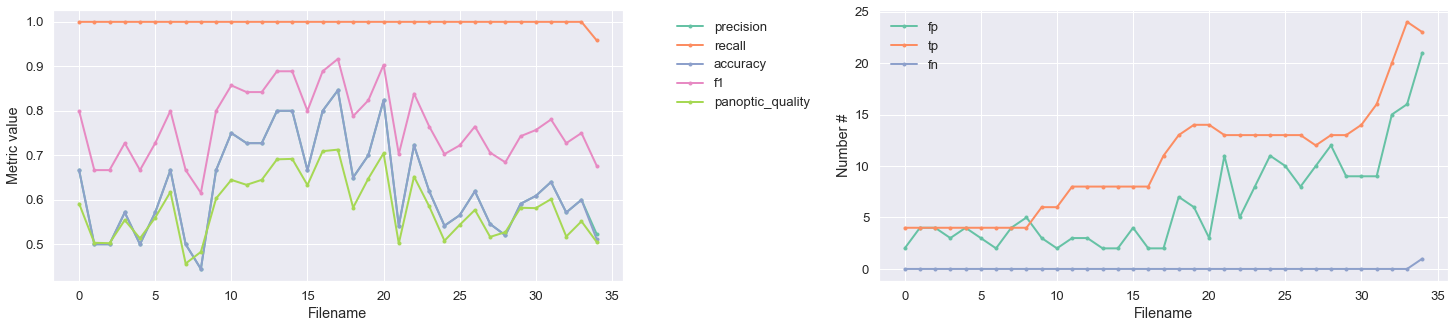

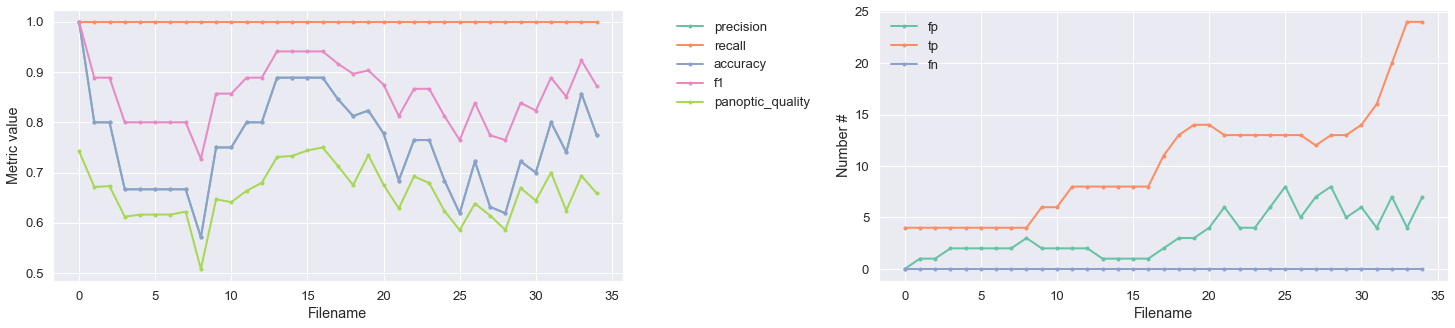

In [23]:
# look at the metrics per frame in the test set (tau = 0.3)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25,5))
plt.subplots_adjust(wspace=0.45)

for m, fname in zip(('precision', 'recall', 'accuracy', 'f1', 'panoptic_quality'), fnames):
    ax1.plot([i for i, f in enumerate(fnames)], [t for t in [s._asdict()[m] for s in metrics_30f]], '.-', lw=2, label=m)
ax1.set_xlabel(r'Filename')
ax1.set_ylabel('Metric value')
ax1.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.35, 1))

for m in ('fp', 'tp', 'fn'):
    ax2.plot([i for i, f in enumerate(fnames)], [t for t in [s._asdict()[m] for s in metrics_30f]], '.-', lw=2, label=m)
ax2.set_xlabel(r'Filename')
ax2.set_ylabel('Number #')
ax2.legend(frameon=False)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25,5))
plt.subplots_adjust(wspace=0.45)

for m, fname in zip(('precision', 'recall', 'accuracy', 'f1','panoptic_quality'), fnames):
    ax1.plot([i for i, f in enumerate(fnames)], [t for t in [s._asdict()[m] for s in metrics_52f]], '.-', lw=2, label=m)
ax1.set_xlabel(r'Filename')
ax1.set_ylabel('Metric value')
ax1.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.35, 1))

for m in ('fp', 'tp', 'fn'):
    ax2.plot([i for i, f in enumerate(fnames)], [t for t in [s._asdict()[m] for s in metrics_52f]], '.-', lw=2, label=m)
ax2.set_xlabel(r'Filename')
ax2.set_ylabel('Number #')
ax2.legend(frameon=False)

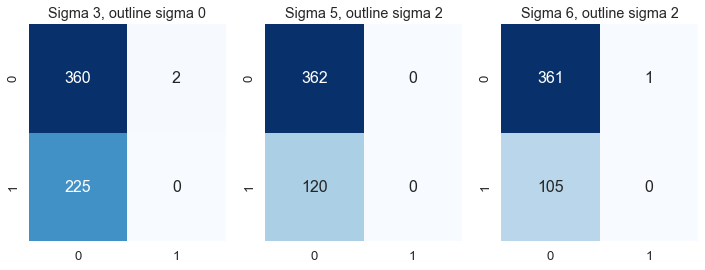

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
labels = ["Sigma 3, outline sigma 0", "Sigma 5, outline sigma 2", "Sigma 6, outline sigma 2"]
metrics = [metrics_30[3], metrics_52[3], metrics_62[3]]
for met, ax,lbl in zip(metrics, axes.flatten(), labels):
    cm_data_1 = []
    cm_data_2 = []

    for m in ('tp', 'fn', 'fp'):
        if m == "tp" or m == "fn":
            cm_data_1.append(met._asdict()[m])
        elif m == "fp":
            cm_data_2.append(met._asdict()[m])
            
    cm_data_2.append(0)  # tn are not known
    cm_data = [cm_data_1, cm_data_2]
    sns.heatmap(cm_data, annot=True, vmax = 360, cmap='Blues', fmt='d', ax=ax, cbar = False, annot_kws={'fontsize': 16})
    ax.title.set_text(lbl)
    
plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "simple_watershed_cm.png"), bbox_inches='tight')

Confusion matrix should be in the form:<br>
TP|FN <br>
FP|TN (TN - not known in this case)

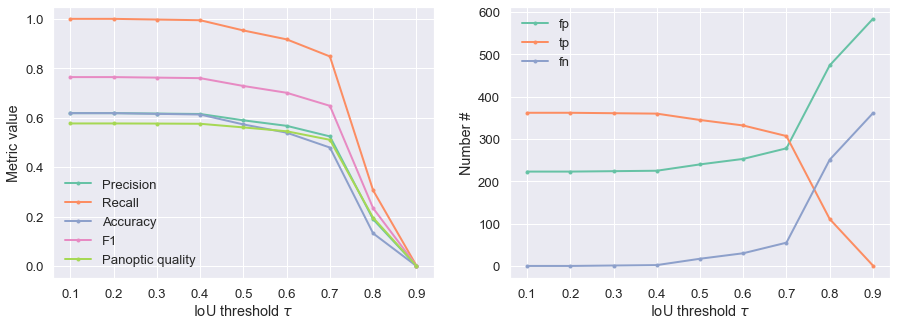

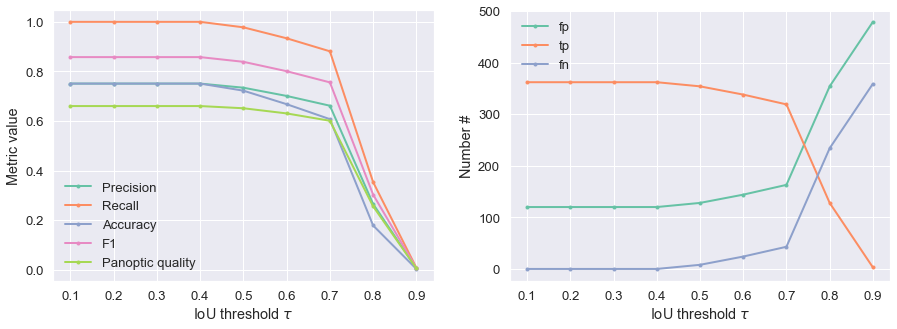

In [54]:
labels = ('Precision', 'Recall', 'Accuracy', 'F1', 'Panoptic quality')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m, lbl in zip(('precision', 'recall', 'accuracy', 'f1', 'panoptic_quality'), labels):
    ax1.plot(taus, [s._asdict()[m] for s in metrics_30], '.-', lw=2, label=lbl)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.legend(frameon=False)

labels2=('False positive', 'True positive', 'False negative')
for m,lbl in zip(('fp', 'tp', 'fn'), labels2):
    ax2.plot(taus, [s._asdict()[m] for s in metrics_30], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.legend(frameon=False)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m, lbl in zip(('precision', 'recall', 'accuracy', 'f1', 'panoptic_quality'), labels):
    ax1.plot(taus, [s._asdict()[m] for s in metrics_52], '.-', lw=2, label=lbl)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.legend(frameon=False)

for m,lbl in zip(('fp', 'tp', 'fn'), labels2):
    ax2.plot(taus, [s._asdict()[m] for s in metrics_52], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.legend(frameon=False)

## Boundary based metrics

In [149]:
# tolerance is 3 pixels, values provided in mm because Surface Distance library has in the documentation mm. Returned values are already in microns
res_df = get_boundary_based_metrics_per_object(predictions2, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [06:51<00:00, 11.75s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [153]:
pd.set_option('display.max_rows', res_df.shape[0]+1)
res_df_wo_nans= res_df.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])   # drop NAN values so only values for TP objects are left in the dataframe

In [156]:
final = res_df_wo_nans.reset_index(drop=True)
final

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.528709,0.471722,0.847523,0.462980,0.589455,0.520162,0.842221
1,0.497307,0.451979,0.792786,0.561371,0.672167,0.611785,0.853356
2,0.530537,0.462899,0.931634,0.548466,0.707261,0.617415,0.852102
3,0.484017,0.430466,0.811442,0.609036,0.754953,0.672104,0.861012
4,0.538928,0.472740,0.865000,0.479748,0.629811,0.547312,0.844504
5,0.489784,0.460391,0.792786,0.576307,0.695618,0.630288,0.860511
6,0.509789,0.444747,0.865000,0.581937,0.759511,0.658834,0.862264
7,0.474565,0.421219,0.773680,0.645376,0.794039,0.710236,0.874778
8,0.517377,0.458988,0.865000,0.515473,0.664533,0.582359,0.850743
9,0.503882,0.455306,0.811442,0.553394,0.686691,0.613264,0.857472


In [157]:
final.to_csv(r"exp16_distance_metrics_df.csv")

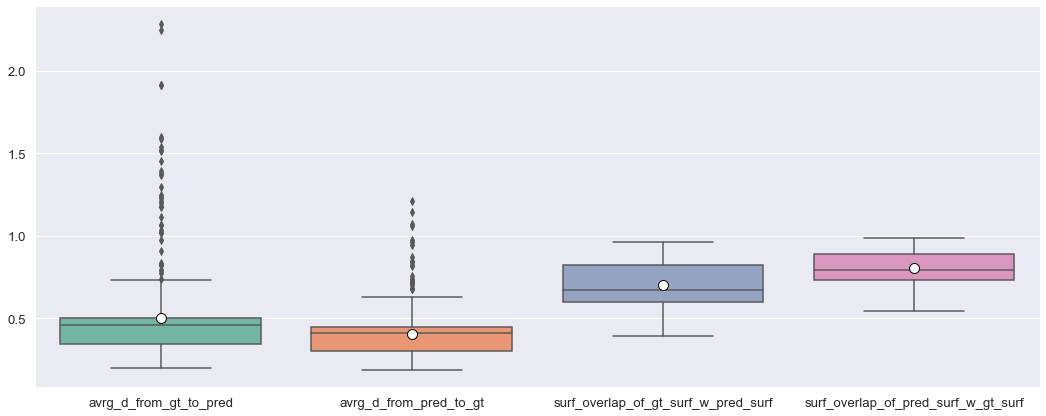

In [188]:
f, ax = plt.subplots(1, figsize = (18,7))

sns.boxplot(data=final[["avrg_d_from_gt_to_pred", "avrg_d_from_pred_to_gt", "surf_overlap_of_gt_surf_w_pred_surf", "surf_overlap_of_pred_surf_w_gt_surf"]], showmeans=True, ax = ax,meanprops={"marker":"o",
                                                                                                                                                                                               "markerfacecolor":"white", 
                                                                                                                                                                                               "markeredgecolor":"black",                                                                                                                                                                                         "markersize":"10"})
plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "exp16_distance_metrics_boxplot.png"), bbox_inches='tight')

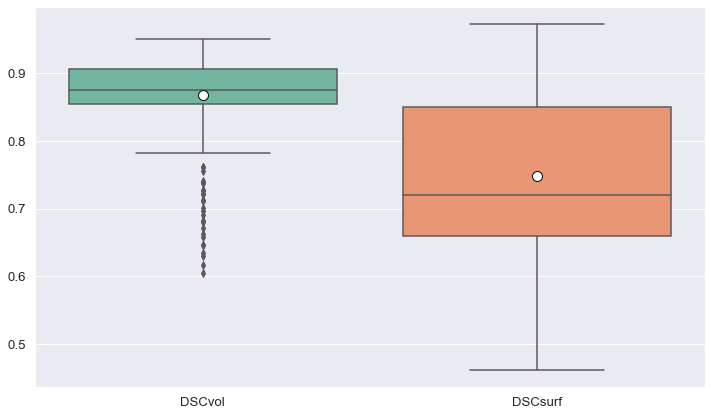

In [189]:
f, ax = plt.subplots(1, figsize = (12,7))

sns.boxplot(data=final[["DSCvol", "DSCsurf"]], showmeans=True, ax = ax,meanprops={"marker":"o",
                                                                                  "markerfacecolor":"white", 
                                                                                  "markeredgecolor":"black",
                                                                                  "markersize":"10"})

plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "exp16_distance_metrics_boxplot_DSCvol_and_surf.png"), bbox_inches='tight')

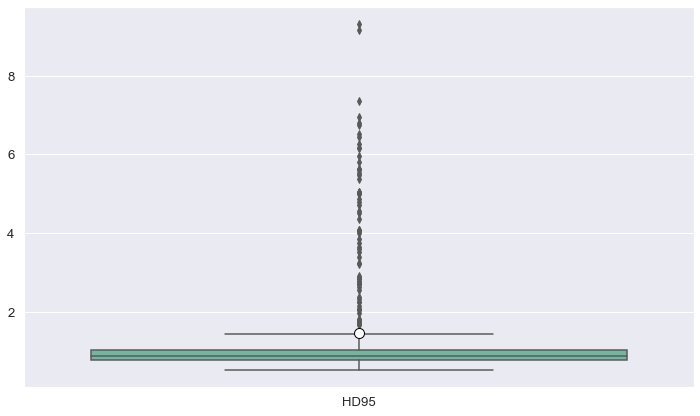

In [190]:
f, ax = plt.subplots(1, figsize = (12,7))

sns.boxplot(data=final[["HD95"]], showmeans=True, ax = ax,meanprops={"marker":"o",
                                                                                  "markerfacecolor":"white", 
                                                                                  "markeredgecolor":"black",
                                                                                  "markersize":"10"})

plt.savefig(os.path.join(module_path, "reports", "figures", "watershed", "exp16_distance_metrics_HD95.png"), bbox_inches='tight')

In [160]:
metrics_52[2]

DatasetMatching(criterion='iou', thresh=0.3, fp=120, tp=362, fn=0, precision=0.7510373443983402, recall=1.0, accuracy=0.7510373443983402, f1=0.8578199052132701, n_true=362, n_pred=482, mean_true_score=0.769906032809895, mean_matched_score=0.769906032809895, panoptic_quality=0.6604407200881091, by_image=False)

In [194]:
metrics_combined = {
    'Mean distance from the GT to predicted surface in microns': final["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": final["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": final["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": final["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": final["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": final["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": final["DSCvol"].mean(),
}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics_52[2]._asdict()[m]
metrics_combined

{'Mean distance from the GT to predicted surface in microns': 0.5030099349194371,
 'Mean distance from predicted to the GT surface in microns': 0.4048897756148519,
 'Mean Hausdorff95 distance': 1.4552437479117954,
 'Mean surface overlap fraction of GT surfaces with predicted surfaces': 0.7030766486716937,
 'Mean surface overlap fraction of the predicted surfaces with the GT surfaces': 0.8037723136960558,
 'Mean surface DSC': 0.7479515637930697,
 'Mean volume DSC over matched objects': 0.8670868263239402,
 'tp': 362,
 'fn': 0,
 'fp': 120,
 'precision': 0.7510373443983402,
 'recall': 1.0,
 'accuracy': 0.7510373443983402,
 'f1': 0.8578199052132701,
 'mean_true_score': 0.769906032809895,
 'mean_matched_score': 0.769906032809895,
 'panoptic_quality': 0.6604407200881091}

In [195]:
import json

with open("exp16_metrics.json", "w") as f:
    json.dump(metrics_combined, f) 